In [1]:
import os
import math
import sys
from collections import defaultdict

from typing import List, Optional, Union, Dict

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import torch
import torch.utils.data
from transformers import AutoTokenizer, BatchEncoding, PreTrainedTokenizerBase

sns.set_theme(style='darkgrid', font_scale=1.5, 
              rc={'font.family':'serif', 'font.serif':'Times New Roman'})

In [2]:
PROJECT_FOLDER = os.path.dirname(os.path.abspath(''))
DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data')
MODELS_FOLDER = os.path.join(PROJECT_FOLDER, 'models')

if PROJECT_FOLDER not in sys.path:
    sys.path.append(PROJECT_FOLDER)

In [3]:
model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=os.path.join(MODELS_FOLDER, model_name))
print(f"Tokenizer {model_name} loaded.")

Tokenizer bert-base-uncased loaded.


In [4]:
from src.data.data_processing import get_task_processor, get_examples_from_dataset, _get_label_id

def get_data(task_name: str, set_name: str, tokenizer: PreTrainedTokenizerBase, raw_data_dir: str):
    processor = get_task_processor(task_name)
    examples = get_examples_from_dataset(processor, raw_data_dir, set_name)

    labels = [example.label for example in examples]
    
    texts_a = []
    texts_b = []
    
    for (ex_index, example) in enumerate(examples):
        texts_a.append(example.text_a)
        if example.text_b is not None:
            texts_b.append(example.text_b)

    if len(texts_a) == len(texts_b):
        text_tokenized = tokenizer(
            texts_a,
            texts_b,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=False,
            truncation=False,
            padding=False,
            return_length=True
        )
    else:
        text_tokenized = tokenizer(
            texts_a,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=False,
            truncation=False,
            padding=False,
            return_length=True
        )
    
    text_tokens = text_tokenized['input_ids']
    lengths = text_tokenized['length']
    return texts_a, text_tokens, labels, lengths

In [78]:
def analyse(task_name, set_name, tokenizer, data_dir):
    texts, text_tokens, labels, lengths = get_data(task_name, set_name=set_name, tokenizer=tokenizer, raw_data_dir=data_dir)

    task_name_display = task_name.replace('_', ' ').upper()
    set_name_diaplay = set_name.upper()
    
    df = pd.DataFrame({'text': texts, 'label': labels, 'length': lengths})
    labels_unique = np.sort(df.label.unique())
    
    # Labels count
    fig = plt.figure(figsize=(16, 6.5))
    gs = fig.add_gridspec(1, 3)
    
    ax1 = fig.add_subplot(gs[0])
    sns.countplot(x='label', data=df, order=labels_unique, ax=ax1)
    ax1.set_title(f'Labels count')
    fig.tight_layout()

    # Seuqence length histogram
    ax2 = fig.add_subplot(gs[1:])
    sns.histplot(x='length', data=df, ax=ax2)
    max_val = max([p.get_height() for p in ax2.patches])
    for q, ls in zip([0.75, 0.95, 0.99], [(0, (5, 5)), (0, (5, 4)),  (0, (5, 2))]):
        qv = int(df['length'].quantile(q))
        ax2.axvline(qv, color='red', ls=ls, lw=1.5, label=q)
        ax2.annotate(qv, xy=(qv, max_val * 0.8), xytext = (qv + 9, max_val * 0.85),
                     arrowprops=dict(arrowstyle = "->", color='black'))

    ax2.legend(title='Quantile')
    ax2.set_title(f'Sequence length histogram')
    
    fig.suptitle(f'{task_name_display} -- {set_name_diaplay} set')
    fig.tight_layout()
#     fig.savefig(f'{task_name}_{set_name}_analysis.png', dpi=300)

## Poziom zdaniowy

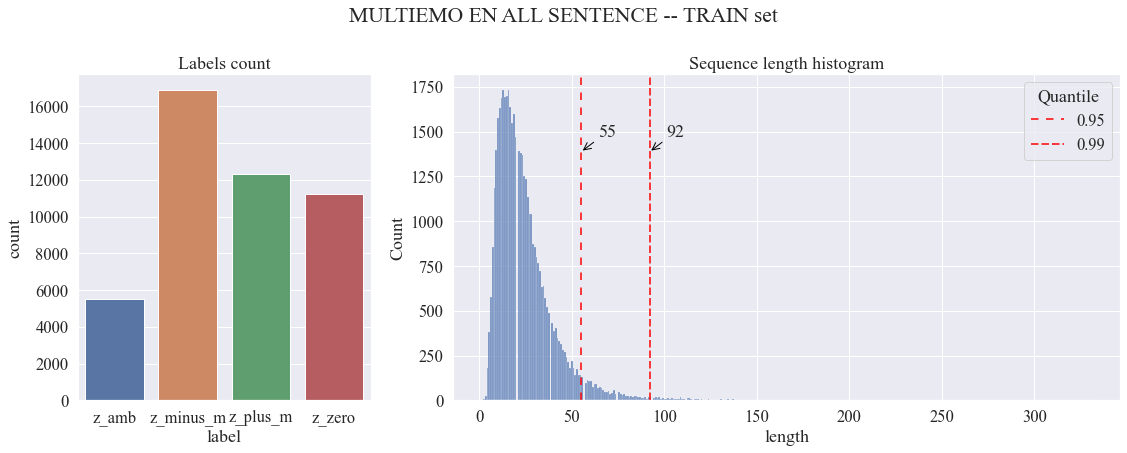

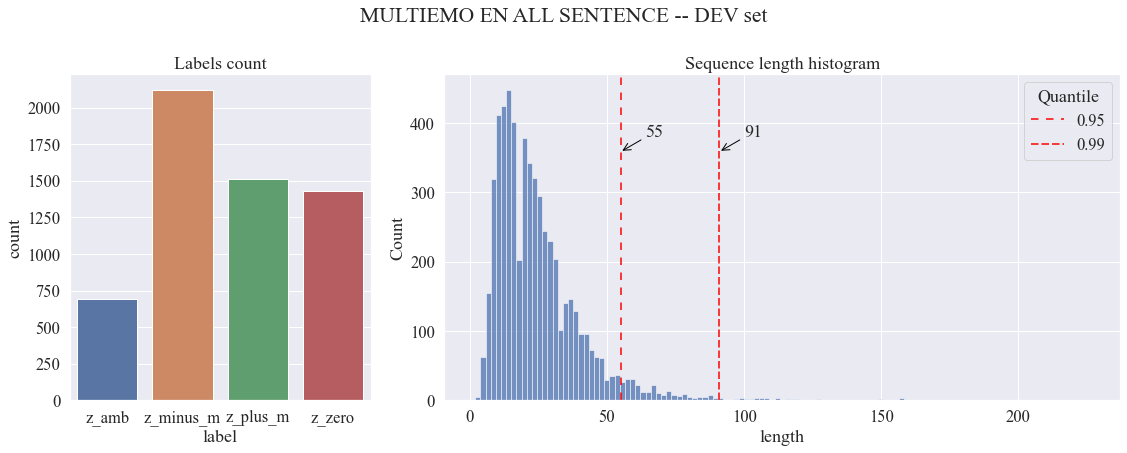

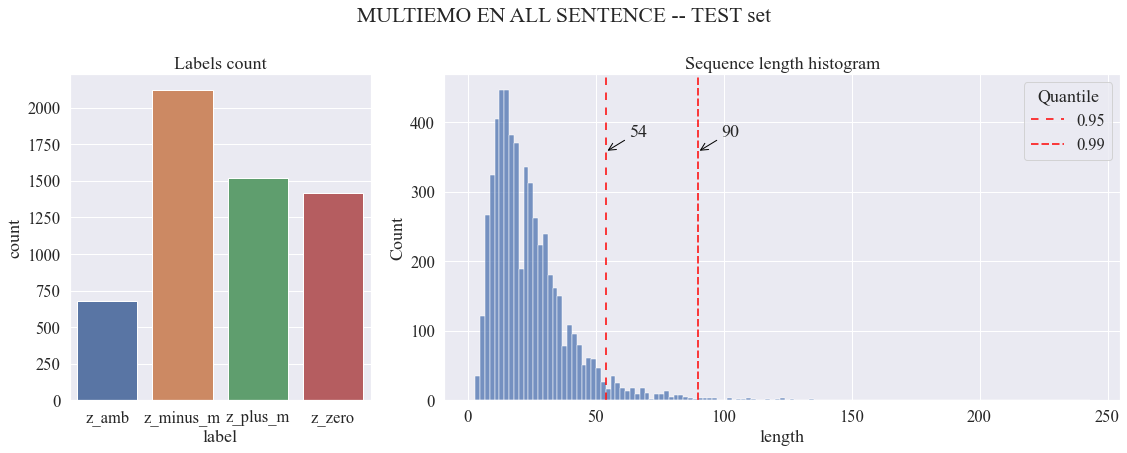

In [76]:
task_name = 'multiemo_en_all_sentence'
data_dir = os.path.join(DATA_FOLDER, 'multiemo2')

for set_name in ['train', 'dev', 'test']:
    analyse(task_name, set_name, tokenizer, data_dir)

## Poziom tekstowy

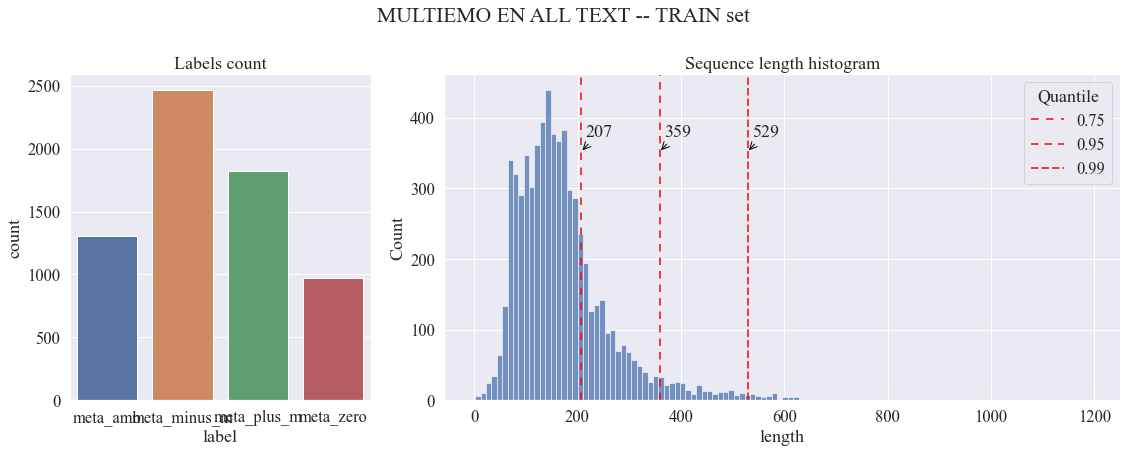

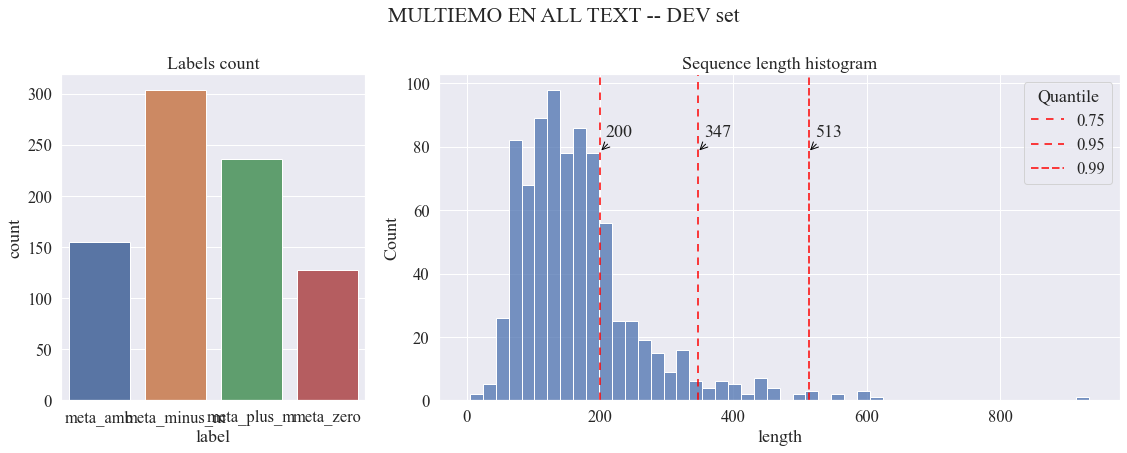

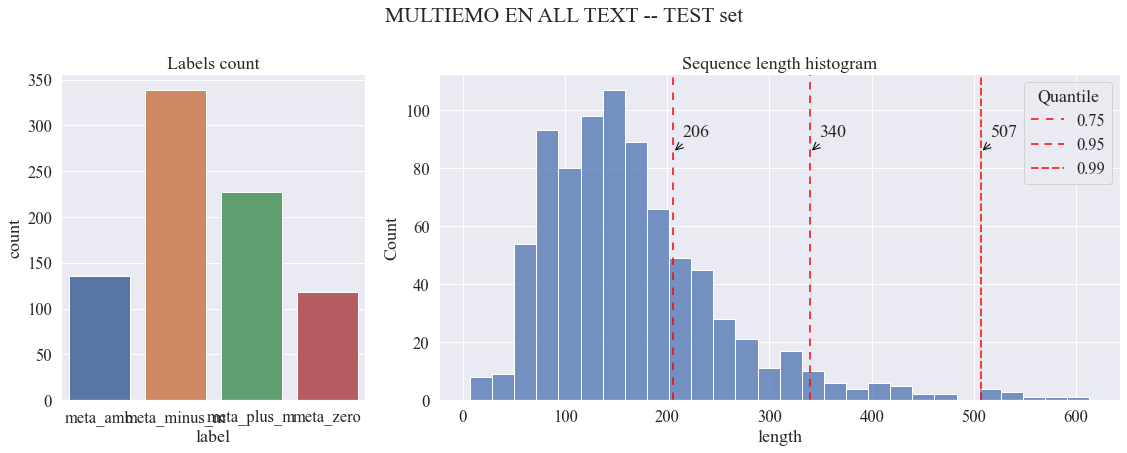

In [79]:
task_name = 'multiemo_en_all_text'
data_dir = os.path.join(DATA_FOLDER, 'multiemo2')

for set_name in ['train', 'dev', 'test']:
    analyse(task_name, set_name, tokenizer, data_dir)